# Project: Wrangling and Analyze Data

## Import packages

In [1]:
# Import packages for the project
import pandas as pd
import numpy as np
import os
import seaborn as sns
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

* **I did not download the file from Twitter but the file that was provided.**

In [2]:
# Load the twitter archive
twit_arch_df = pd.read_csv('twitter_archive_enhanced.csv')

In [3]:
twit_arch_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
# Download image_predictions.tsv
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image_predictions.tsv', mode ='wb') as file:
    file.write(response.content)
img_pred_df = pd.read_csv('image_predictions.tsv', sep='\t')

In [5]:
img_pred_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

* **I did not download the file from Twitter but the file that was provided.**
* **The code down below was copied from twitter_api.py**

In [ ]:
import tweepy
from tweepy import OAuthHandler
#import json
from timeit import default_timer as timer

consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df_1.tweet_id.values
len(tweet_ids)

count = 0
fails_dict = {}
start = timer()

with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [6]:
tweet_list = []

with open('tweet_json.txt', 'r', encoding='utf8') as file:
    for each_line in file:
        for_lines = json.loads(each_line)
        tweet_list.append({'tweet_id': for_lines['id'],
                        'favorites': for_lines['favorite_count'],
                        'retweets': for_lines['retweet_count'],
                        'timestamp': for_lines['created_at']})
tweet_df = pd.DataFrame(tweet_list, columns=['tweet_id','favorites','retweets', 'timestamp'])

In [7]:
tweet_df.head()

,tweet_id,favorites,retweets,timestamp
0,892420643555336193,39467,8853,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,33819,6514,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,25461,4328,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,42908,8964,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,41048,9774,Sat Jul 29 16:00:24 +0000 2017


In [8]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id     2354 non-null int64
favorites    2354 non-null int64
retweets     2354 non-null int64
timestamp    2354 non-null object
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Visual Assessment

**twit_arch_df**

In [9]:
twit_arch_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
twit_arch_df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [11]:
twit_arch_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
twit_arch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

* The in reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp columns all have several missing values.
* Those columns where not needed because there are retweets.

**img_pred_df**

In [13]:
img_pred_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [14]:
img_pred_df.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [15]:
img_pred_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [16]:
img_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


**tweet_df**

In [17]:
tweet_df.head()

,tweet_id,favorites,retweets,timestamp
0,892420643555336193,39467,8853,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,33819,6514,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,25461,4328,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,42908,8964,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,41048,9774,Sat Jul 29 16:00:24 +0000 2017


In [18]:
tweet_df.tail()

,tweet_id,favorites,retweets,timestamp
2349,666049248165822465,111,41,Mon Nov 16 00:24:50 +0000 2015
2350,666044226329800704,311,147,Mon Nov 16 00:04:52 +0000 2015
2351,666033412701032449,128,47,Sun Nov 15 23:21:54 +0000 2015
2352,666029285002620928,132,48,Sun Nov 15 23:05:30 +0000 2015
2353,666020888022790149,2535,532,Sun Nov 15 22:32:08 +0000 2015


In [19]:
tweet_df.describe()

,tweet_id,favorites,retweets
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


In [20]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id     2354 non-null int64
favorites    2354 non-null int64
retweets     2354 non-null int64
timestamp    2354 non-null object
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


### Programmatic Assessment

In [21]:
twit_arch_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [22]:
twit_arch_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [23]:
twit_arch_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [24]:
twit_arch_df.duplicated().sum()

0

### Quality issues
1. "timestamp" in twit_arch_df and tweet_df should be date-time instead of object, tweet_id columns should be objetct (string) not int and "dog_designation" column as category.

2. There are 23 instances where the rating's denominator is more than 10. This information will be deleted. These instances, however, only make up a minor portion of the data set and may be ignored for the time being.

3. To make the finished dataset more organized, remove some unneeded columns.

4. Replace all the "None"-Values with "NaN"-Value.

5. The "Name"-Column has some names with no real dog names.

6. Dog breeds in the img_pred_df columns p1, p2, p3 are sometimes uppercase and lowercase.

7. Some retweets are basically identical copies of the original tweets. In the Dataset, we do not want those retweets.

8. "timestamp" columns have some zeros "0000" in it.

### Tidiness issues
1. Joining all three DF's to one DF.

2. (doggo, floofer, pupper, puppo) are in several columns, one column would be fine.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [25]:
# Make copies of original pieces of data
twit_arch_df_clean = twit_arch_df.copy()
tweet_df_clean = tweet_df.copy()
img_pred_df_clean = img_pred_df.copy()

### Issue #1: Joining all three DF's to one DF.

#### Define: I start with merging all three DF's on the unique identifier "tweet_id"

#### Code

In [26]:
df_merged1 = pd.merge(twit_arch_df_clean, tweet_df_clean, left_on="tweet_id", right_on="tweet_id", how="inner")
df_merged2 = pd.merge(df_merged1, img_pred_df_clean, left_on="tweet_id", right_on="tweet_id", how='inner')
df_clean = df_merged2

#### Test

In [27]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 31 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp_x                   2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
favorites                     2073 

In [28]:
df_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False


### Issue #2: (doggo, floofer, pupper, puppo) are in several columns, one column would be fine.

#### Define: Merge the four columns "doggo, floofer, pupper and puppo" into one column dog_designation.

#### Code

In [29]:
df_clean.loc[df_clean.pupper == 'None', 'pupper'] = ''
df_clean.loc[df_clean.doggo == 'None', 'doggo'] = ''
df_clean.loc[df_clean.puppo == 'None', 'puppo'] = ''
df_clean.loc[df_clean.floofer == 'None', 'floofer'] = ''

df_clean.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1753
1,,,,puppo,23
2,,,pupper,,210
3,,floofer,,,7
4,doggo,,,,67
5,doggo,,,puppo,1
6,doggo,,pupper,,11
7,doggo,floofer,,,1


In [30]:
df_clean['dog_designation'] = df_clean.puppo + df_clean.doggo + df_clean.pupper + df_clean.floofer
df_clean.loc[df_clean.dog_designation == 'puppodoggo', 'dog_designation'] = 'puppo, doggo'
df_clean.loc[df_clean.dog_designation == 'doggopupper', 'dog_designation'] = 'doggo, pupper'
df_clean.loc[df_clean.dog_designation == 'doggofloofer', 'dog_designation'] = 'doggo, floofer'

df_clean.loc[df_clean.dog_designation == '', 'dog_designation'] = 'None'

#### Test

In [31]:
df_clean.dog_designation.value_counts()

None              1753
pupper             210
doggo               67
puppo               23
doggo, pupper       11
floofer              7
doggo, floofer       1
puppo, doggo         1
Name: dog_designation, dtype: int64

## The Tidiness issues i stated are finished and now i go ahead to the Quality issues

### Issue #3: "timestamp" in twit_arch_df and tweet_df should be date-time instead of object.
###                  "tweet_id" column should be objetct (string) not int.
###                  "dog_designation" column as category.

#### Define: Change the datatypes of some columns, also rename the timestamp_x to timestamp and fix "timestamp" columns have some zeros "0000" in it.

#### Code

In [32]:
df_clean['dog_designation'] = df_clean['dog_designation'].astype('category')
df_clean['tweet_id'] = df_clean['tweet_id'].astype(str)
df_clean['timestamp_x'] = pd.to_datetime(df_clean.timestamp_x)
df_clean.rename(columns={"timestamp_x": "timestamp"}, inplace=True)

#### Test

In [33]:
df_clean.dtypes

tweet_id                              object
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
favorites                              int64
retweets                               int64
timestamp_y                           object
jpg_url                               object
img_num                                int64
p1        

In [34]:
df_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_designation
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False,None


* #### After fixing the datatype of "timestamp" the "0000" also disappeared so fixed 2 problems in 1 go.

### Issue #4: There are 23 instances where the rating's denominator is more than 10. This information will be deleted. These instances, however, only make up a minor portion of the data set and may be ignored for the time being.

#### Define: Droping the 23 rows with a denominator more or less then 10 so the rating is consistent.

#### Code

In [35]:
df_clean.drop(df_clean[df_clean.rating_denominator != 10].index, inplace = True)

#### Test

In [36]:
df_clean.rating_denominator.value_counts()

10    2055
Name: rating_denominator, dtype: int64

### Issue #5: To make the finished dataset more organized, remove some unneeded columns.

#### Define: Drop the columns i think we wont need for any futher analysis.

#### Code

In [37]:
df_clean = df_clean.drop('doggo', 1)
df_clean = df_clean.drop('floofer', 1)
df_clean = df_clean.drop('pupper', 1)
df_clean = df_clean.drop('puppo', 1)
df_clean = df_clean.drop('timestamp_y', 1)

#### Test

In [38]:
list(df_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'favorites',
 'retweets',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_designation']

### Issue #6: Some retweets are basically identical copies of the original tweets. In the Dataset, we do not want those retweets.

#### Define: Here i drop those 5 columns with the retweets so we dont have duplicated tweets.

#### Code

In [39]:
df_clean = df_clean.drop('retweeted_status_id', 1)
df_clean = df_clean.drop('retweeted_status_user_id', 1)
df_clean = df_clean.drop('retweeted_status_timestamp', 1)
df_clean = df_clean.drop('in_reply_to_status_id', 1)
df_clean = df_clean.drop('in_reply_to_user_id', 1)

#### Test

In [40]:
list(df_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'favorites',
 'retweets',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_designation']

### Issue #7: Replace all the "None"-Values with "NaN"-Value.

#### Define: Many columns have "None" values therefore these are all converted to "NaN" values.

#### Code

In [41]:
df_clean =  df_clean.replace('None', np.nan)

#### Test

In [42]:
df_clean.isnull().sum()

tweet_id                 0
timestamp                0
source                   0
text                     0
expanded_urls            0
rating_numerator         0
rating_denominator       0
name                   565
favorites                0
retweets                 0
jpg_url                  0
img_num                  0
p1                       0
p1_conf                  0
p1_dog                   0
p2                       0
p2_conf                  0
p2_dog                   0
p3                       0
p3_conf                  0
p3_dog                   0
dog_designation       1735
dtype: int64

In [43]:
df_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweets,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_designation
1771,671497587707535361,2015-12-01 01:14:35,"<a href=""http://twitter.com/download/iphone"" r...",This is Pip. He is a ship captain. Many years ...,https://twitter.com/dog_rates/status/671497587...,11,10,Pip,980,481,...,swing,0.089165,False,paddle,0.080747,False,bathing_cap,0.065694,False,NaN
244,836001077879255040,2017-02-26 23:52:43,"<a href=""http://twitter.com/download/iphone"" r...",Atlas is back and this time he's prettier than...,https://twitter.com/dog_rates/status/836001077...,13,10,NaN,20924,4935,...,Samoyed,0.963558,True,white_wolf,0.019848,False,malamute,0.005904,True,NaN
1135,703611486317502464,2016-02-27 16:03:45,"<a href=""http://twitter.com/download/iphone"" r...",Meet Scooter. He's experiencing the pupper equ...,https://twitter.com/dog_rates/status/703611486...,10,10,Scooter,4229,1709,...,Pembroke,0.756441,True,basenji,0.126621,True,Cardigan,0.080117,True,pupper
175,850753642995093505,2017-04-08 16:54:09,"<a href=""http://twitter.com/download/iphone"" r...","This is Kyle. He made a joke about your shoes,...",https://twitter.com/dog_rates/status/850753642...,11,10,Kyle,33348,10352,...,pug,0.996952,True,bull_mastiff,0.000996,True,French_bulldog,0.000883,True,NaN
1441,680940246314430465,2015-12-27 02:36:20,"<a href=""http://twitter.com/download/iphone"" r...",This is Alice. She's an idiot. 4/10 https://t....,https://twitter.com/dog_rates/status/680940246...,4,10,Alice,3544,1225,...,soft-coated_wheaten_terrier,0.289598,True,West_Highland_white_terrier,0.157195,True,toy_poodle,0.074435,True,NaN


### Issue #8: Dog breeds in the img_pred_df columns p1, p2, p3 are sometimes uppercase and lowercase.

#### Define: The column with the "p-values" are case sensitive. I convert all of them to lower case.

#### Code

In [44]:
p_values = ['p1', 'p2', 'p3']
for value in p_values:
    df_clean[str(value)] = df_clean[str(value)].apply(lambda x: x.lower())

#### Test

In [45]:
df_clean.p1.sample(5), df_clean.p2.sample(5), df_clean.p3.sample(5)

(685                      toy_poodle
 392                  french_bulldog
 1667    german_short-haired_pointer
 1436                  motor_scooter
 2048                       malamute
 Name: p1, dtype: object, 421     golden_retriever
 272               marmot
 1739      french_bulldog
 1236          toy_poodle
 1763        water_bottle
 Name: p2, dtype: object, 1890             bulletproof_vest
 195            labrador_retriever
 363            standard_schnauzer
 1195    staffordshire_bullterrier
 179                        bonnet
 Name: p3, dtype: object)

### Issue #9: The "Name"-Column has some lowercase names with no real dog names.

#### Define: Replace those weired names with NaN.

#### Code

In [46]:
df_clean.name = df_clean.name.mask(df_clean.name.str.islower().fillna(False))

#### Test

In [47]:
len(df_clean.name[df_clean.name.str.islower().fillna(False)])

0

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [48]:
df_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [49]:
df_clean['name'].value_counts()

Charlie     11
Tucker      10
Lucy        10
Penny       10
Cooper      10
Oliver      10
Bo           8
Winston      8
Lola         8
Sadie        8
Toby         7
Daisy        7
Dave         6
Scout        6
Milo         6
Rusty        6
Bailey       6
Koda         6
Stanley      6
Bella        6
Jax          6
Louis        5
Oscar        5
Alfie        5
Leo          5
Chester      5
Larry        5
Buddy        5
Cassie       4
Phil         4
            ..
Fillup       1
Tilly        1
Huxley       1
Stefan       1
Timber       1
Gin          1
Eevee        1
Bubba        1
Suki         1
Berb         1
Beebop       1
Ace          1
Pawnd        1
Jennifur     1
Jarvis       1
Gustav       1
Daniel       1
Clarq        1
Anna         1
Monkey       1
Kona         1
Simba        1
Joshwa       1
Tripp        1
Mingus       1
Lulu         1
Jarod        1
Jett         1
General      1
Jeremy       1
Name: name, Length: 911, dtype: int64

In [50]:
df_clean['p1'].value_counts()

golden_retriever             146
labrador_retriever            97
pembroke                      88
chihuahua                     83
pug                           57
chow                          44
samoyed                       43
toy_poodle                    39
pomeranian                    38
cocker_spaniel                30
malamute                      30
french_bulldog                26
miniature_pinscher            23
chesapeake_bay_retriever      23
seat_belt                     22
staffordshire_bullterrier     20
german_shepherd               20
cardigan                      19
web_site                      19
siberian_husky                19
shetland_sheepdog             18
beagle                        18
eskimo_dog                    18
teddy                         17
maltese_dog                   17
rottweiler                    17
shih-tzu                      17
lakeland_terrier              17
italian_greyhound             16
kuvasz                        16
          

In [51]:
df_clean['rating_numerator'].value_counts()

12      473
10      429
11      413
13      283
9       150
8        95
7        51
14       40
5        34
6        32
3        19
4        15
2         9
1         4
0         2
75        1
26        1
420       1
27        1
15        1
1776      1
Name: rating_numerator, dtype: int64

In [52]:
df_clean['rating_numerator'].describe()

count    2055.000000
mean       11.705596
std        40.058908
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

### Insights:
1. Most 6 common Dog names in this Dataset are "Charlie, Tucker, Lucy, Penny, Copper and Oliver"

2. The Most Popular Dog Is The Golden Retriever, Based On P1 Photo Predictions.

3. The Most common Rating out of ten is a 12/10 with 473 entries. The highest was 1776 and the lowest was 0. The mean rating is 11.7.

4. The Most common Dog Designations.

5. It looks like the more favorites a post has the more retweets it gets.

### Visualization

#### Most common Dog Designation

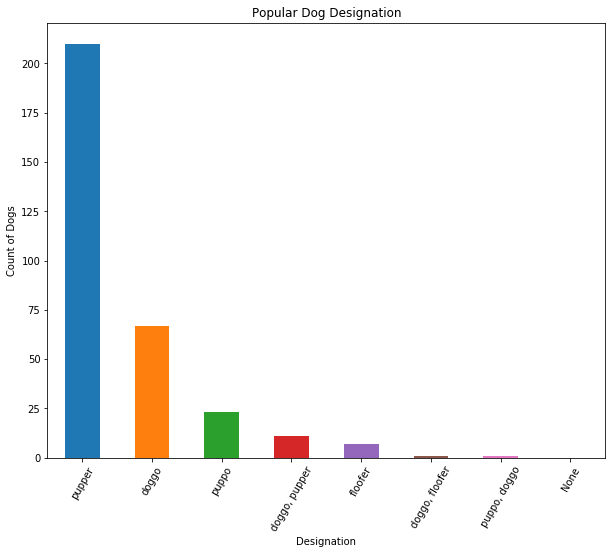

In [53]:
plt.figure(figsize=(10,8))
df_clean.dog_designation.value_counts().sort_values(ascending=False).plot.bar()
plt.title("Popular Dog Designation")
plt.xlabel("Designation")
plt.ylabel("Count of Dogs")
plt.xticks(rotation=60);

#### Correlation between Retweets and Favorite

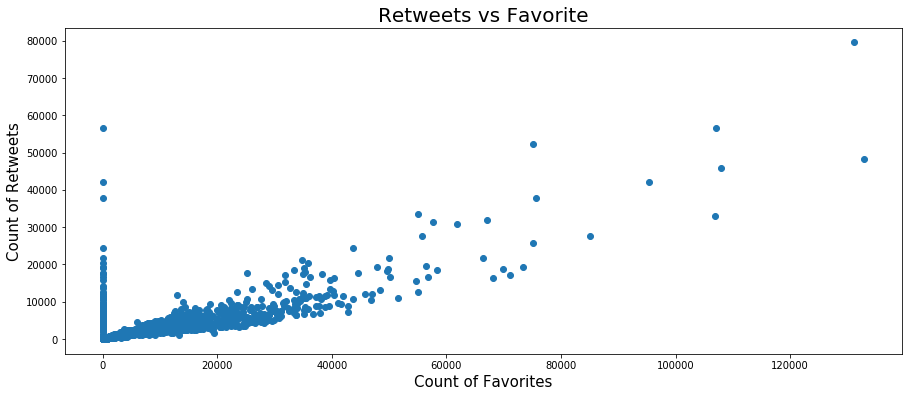

In [54]:
plt.figure(figsize=(15,6))
plt.title("Retweets vs Favorite", size=20)
plt.scatter(x='favorites', y='retweets', data=df_clean)
plt.ylabel("Count of Retweets", size=15)
plt.xlabel("Count of Favorites", size=15);